### Transferência de Aprendizado - Transfer Learning

A transferência de aprendizado ou transferência indutiva é um problema de pesquisa na aprendizagem de máquina que se concentra na utilização do conhecimento adquirido ao resolver um problema para aplicá-lo a um problema diferente, mas relacionado.

In [2]:
%matplotlib inline

from vis.visualization import visualize_saliency, overlay, visualize_cam, visualize_activation, get_num_filters
from keras import activations
import warnings
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Model, Sequential
from keras.models import load_model
from keras.models import model_from_json
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras import backend as K
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from vis.utils import utils
from pickle import dump, load
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from imageio import imread
from skimage.transform import resize
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy.ndimage.filters import convolve

from tensorflow import logging
logging.set_verbosity(logging.FATAL)

Using TensorFlow backend.


O script a seguir assume a seguinte organização de diretórios:
    
```
➜  ~/data tree -L 2
.
├── train
│   ├── cat
│   └── dog
└── val
    ├── cat
    └── dog

6 directories, 0 files
```

Vamos definir algumas constantes:

In [3]:
img_width, img_height = 224, 224

# contém as imagens de treinamento, eu utilizei um split de 90-10 para que a validação não tomasse muito tempo e
# pudessemos treinar a rede apenas uma época
# dado o volume de imagens ~30k existe um "bom" conjunto de validação 

base_dir = '/home/sage/data/catsvsdogs'

train_data_dir =  base_dir + '/train' 
validation_data_dir = base_dir + '/val'

model_location = base_dir + '/trained/vgg16_cat_dog_retrained.json'
weights_location = base_dir + '/trained/vgg16_cat_dog_retrained.h5'

headless_model_location = base_dir + '/trained/vgg16_cat_dog_retrained_headless.json'
headless_weights_location = base_dir + '/trained/vgg16_cat_dog_retrained_headless.h5'

files_and_vector_location = base_dir + '/trained/filenames_and_vectors.pkl'

# statements iniciados com '!' representam comandos do bash, que retornam a lista de strings de sua saída
# nestes caso estou contando o numero de jpegs no diretório train_data_dir
nb_train_samples = !find {train_data_dir} | grep jpg | wc -l
nb_train_samples = int(nb_train_samples[0])

nb_validation_samples = !find {validation_data_dir} | grep jpg | wc -l
nb_validation_samples = int(nb_validation_samples[0])

n_classes = 2

# hyperparams
epochs = 1
batch_size = 16

# dependente do backend, no nosso caso estamos utilizando TF ou 'channels_first'
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    

Vamos começar importando e analisando o modelo VGG16, que será a base dos nossos experimentos. 
Esse modelo é descrito no paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556), por Karen Simonyan e Andrew Zisserman. De acordo com o paper, os autores atingiram um erro top-5 de 7.5% no dataset ILSVRC-2012-val e um erro top-5 de 7.4% top-5 no dataset ILSVRC-2012-test, na competição [ImageNet](https://en.wikipedia.org/wiki/ImageNet) de 2014.

<img style="width:60%;height:auto;padding:0;margin:0" src="images/vgg16.png">

Vamos carregar o modelo da bilioteca padrão do Keras, e definir que os 138.357.544 parâmetros serão inicializados paras os valores obtidos a partir do treinamento no dataset ImageNet, como apresentado no paper. 

In [3]:
# carregando o modelo da biblioteca padrão do Keras
base_model = VGG16(weights='imagenet', include_top=True, input_shape=input_shape)
# inspeção
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### O treinamento de uma única rede com essa arquitetura leva 3 semanas em uma configuração com 4 GPUs NVIDIA GTX Titan Black
A tunagem de hiperparâmetros exige que a rede seja retreinada diversas vezes, até atingir uma boa configuração. A busca por uma boa arquitetura leva ainda mais tempo.

É interessante notar que as três últimas camadas totalmente conectadas (Dense) compreendem uma boa parte dos parâmetros do modelo. Outras arquiteturas posteriores "resolvem" essa explosão de parâmetros utilizando [camadas de pooling médio global](https://arxiv.org/pdf/1312.4400.pdf) (global average pooling layers) e [camadas de convolução NxNx1](https://arxiv.org/pdf/1409.4842.pdf).

In [4]:
'{:2.2f} %'.format((102764544 + 16781312 + 4097000) / 138357544 * 100.)

'89.36 %'

A transferência de conhecimento parte do pressuposto que os parâmetros aprendidos por uma determinada arquitetura neural para resolver um problema de um domínio específico, podem ser reaproveitados para resolver um problema de outro domínio.

**Ao analisarmos as camadas finais da VGG16, vemos um simples classificador: Uma rede neural totalmente conectada.** Os dados de entrada (ou features) que esse classificador utiliza para tomar sua decisão, são a saída do pooling da última camada convolucional. Isso nos diz que, na camada ```block5_pool``` existe informação suficiente para que um classificador relativamente simples (2 camadas escondidas) possa fazer sua predição (E obter um erro top-5 abaixo de 8% em 1000 classes). 

Para avaliar a informação contida nessa camada realizamos um experimento. Selecionamos 3 keyframes de um vídeo contendo 3 objetos, e calculamos o seu vetor de saída.

<div style='display:flex;padding:0;margin:0'>
    <img style="width:33%;height:10%;padding:0;margin:0" src="video/keyframes/livro.jpg">
    <img style="width:33%;height:10%;padding:0;margin:0" src="video/keyframes/raspberry.jpg">
    <img style="width:33%;height:10%;padding:0;margin:0" src="video/keyframes/telefone.jpg">
<div>

Para todas as outras imagens, obtivemos o vetor de saída da mesma camada e calculamos a distância euclideana entre esses vetores e os dos keyframes. O script utilizado para realizar esse experimento encontra-se [aqui](./video/vector_for_frames.py).

In [2]:
from IPython.display import HTML

HTML('<iframe width="800" height="450" src="https://www.youtube.com/embed/eDeG8ubsxjU" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

Como é possível ver no vídeo, as camadas de convolução da rede atuam como um extrator de características, mapeando o espaço de pixeis em um espaço vetorial em que imagens semelhantes ficam muito próximas as outras, e um simples classificador pode separar este espaço entre diversas classes. **Essa rede não foi treinada para classificar Livros, Raspberrys e Telefones.** Mas os parâmetros que ela encontrou pra resolver o problema da ImageNet podem ser aplicados para resolver esse problema, e diversos outros. Vamos explorar melhor o tópico de mapeamento dimensional quando abordamos visualização.

Agora vamos tentar transferir o conhecimento adquirido no dataset ImageNet e treinar a última camada da rede para resolver um problema de benchmark clássico chamado "Cats vs Dogs" do Kaggle, disponível [aqui](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

O dataset original possui 30k imagens, sendo 15k de gatos, e 15k cachorros, e a tarefa é treinar um modelo para diferenciar entre estas duas classes de imagens.

Agora vamos pedir do Keras o mesmo modelo VGG16, entretanto sem as 3 camadas finais, isso é parametrizado pela opção ```include_top```. Você pode executar ```base_model.summary()``` para visualizar as camadas do modelo. Essencialmente ele agora termina em ```block5_pool (MaxPooling2D) (None, 7, 7, 512)``` lhe permitindo "plugar" um classificador em cima deste bloco de features. Aqui utilizamos uma camada de average pooling para "achatar" a largura e a altura do volume, terminando com um vetor de 512 posições, ao invés de "desenrolarmos" o volume, como no paper original. Em cima dessa camada de average pooling, colocaremos apenas uma camada densa de 32 elementos, e uma softmax para realizar a predição.

In [6]:
# Antes de inicializar o novo modelo, vamos desalocar o antigo
# Não fazer isso causa ResourceExhausted na minha GPU de 2GB :<
K.clear_session()

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(32, activation='relu', name='fc1')(x)

prediction = Dense(n_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=base_model.input, outputs=prediction)

Lembre-se que o nosso objetivo aqui é reaproveitar o conhecimento adquirido durante o treinamento de 3 semanas em cima do ImageNet, portanto vamos declarar todas as camadas, exceto a de predições como não-treináveis. Isso significa que só ajustaremos os pesos e biases conectando a camada de average pooling com a densa, e a densa com a softmax. Isso congela o restante do modelo, impedindo que o gradiente flua para além dessas duas camadas.

In [7]:
for layer in model.layers:
    if layer.name in ['fc1', 'predictions']:
        continue
    layer.trainable = False

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Vamos configurar o nosso gerador de imagens de treinamento para fornecer alguma aleatoriedade. No nosso caso o dataset é massivo, diverso e com uma quantidade razoável de ruido (o que é bom para um método de aprendizagem de máquina). Em casos onde dados são mais escassos, esse gerador auxilia a aumentar artificialmente os dados, criando diversas imagens distintas a partir da mesma imagem-base aleatoriamente. Em um treinamento com diversas épocas, isso é muito benéfico ao treinamento. Leia:

* [Image Preprocessing](https://keras.io/preprocessing/image/) - Keras Docs

In [9]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=train_data_dir,
                                                    target_size=[img_width, img_height],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    follow_links=True)

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(directory=validation_data_dir,
                                                              target_size=[img_width, img_height],
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              follow_links=True, 
                                                              shuffle=False)

Found 23529 images belonging to 2 classes.
Found 1240 images belonging to 2 classes.


Vamos ver o que o o nosso gerador está fazendo:

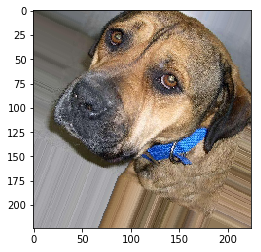

In [10]:
sample, _ = next(train_generator)

plt.imshow(256. - sample[0])

plt.show()

Agora vamos configurar o modelo para treinamento, a nossa perda será a entropia cruzada categórica, e o método de otimização o RMSprop, veja:

* [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/) - Sebastian Ruder

* [Keras Optmizers](https://keras.io/optimizers/) - Keras Docs

* [Keras Losses](https://keras.io/losses/) - Keras Docs

In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### É hora do SHOW!!!!

A natureza de ```ImageDataGenerator``` é de gerar batches de imagens em formato tensorial com aumento artificial em tempo real indefinidamente, percorrendo todo o dataset até recomeçar do seu início. Isso deixa a cargo do cliente o controle das épocas. Por isso utilizamos ```steps_per_epoch``` para impedir mais de 1 loop pelo dataset por época.

In [12]:
# algumas imagens possuem dados EXIF corrompidos
# para não bagunçar a saída dessa célula vamos suprimir alguns warnings
warnings.simplefilter("ignore") 

In [13]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch= nb_train_samples // batch_size // 3,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/1
490/490 [==============================] - 695s 1s/step - loss: 0.3080 - acc: 0.8966 - val_loss: 0.1173 - val_acc: 0.9594


Ao final precisamos salvar o modelo, para isso armazenaremos a definição do modelo em formato .json, e os pesos em .h5

In [15]:
!touch {weights_location}

model.save_weights(weights_location)

model_json_final = model.to_json()

with open(model_location, 'w+') as json_file:
    json_file.write(model_json_final)

Agora vamos resetar novamente a sessão, e recarregar nosso modelo do disco:

In [4]:
K.clear_session()

with open(model_location, 'r') as myfile:
    model_json = myfile.read()

model = model_from_json(model_json)
model.load_weights(weights_location)

Vamos pegar algumas imagens do set de validação, e ver como o nosso modelo as classifica

In [75]:
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(directory=validation_data_dir,
                                                              target_size=[img_width, img_height],
                                                              batch_size=1,
                                                              class_mode='categorical',
                                                              follow_links=True, 
                                                              shuffle=True)

Found 1240 images belonging to 2 classes.


{'cat': 0.97470021, 'dog': 0.025299771}
predicted class: cat


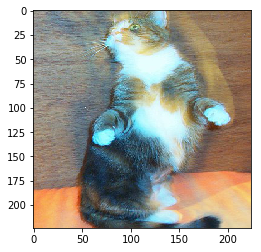

In [5]:
sample, _ = next(validation_generator)

y_pred = model.predict(sample)

img = 256. - sample[0] ## vgg images end up being negatives for some reason

cat_score, dog_score = y_pred[0][0], y_pred[0][1]

print({'cat': cat_score, 'dog': dog_score})
print('predicted class:', 'cat' if cat_score > dog_score else 'dog')

plt.imshow(img)

# Visualizando e entendendo redes de convolução

Ok, nosso modelo parece funcionar muito bem para este domínio. Mas isso propõe uma questão: Como ele atingiu esse desempenho?

Para responder essa pergunta, vamos olhar ** dentro ** da rede.

<img src='images/godeeper.jpg'/>

### Visualizando os Filtros das Camadas Convolucionais

Vamos começar observando o valor dos pesos para a primeira camada de convolução e como eles transformam a imagem de entrada.

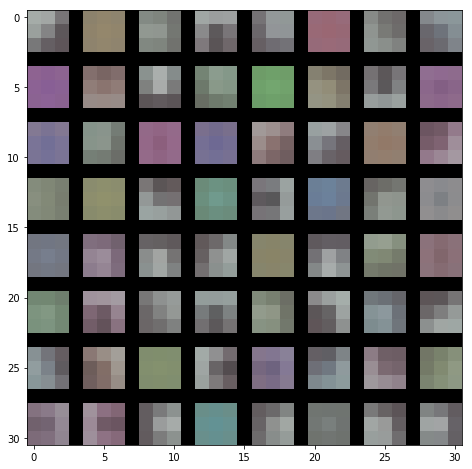

In [102]:
plt.rcParams['figure.figsize'] = (24, 8)

# pegar o tensor de pesos dos filtros da primeira camada
W = model.layers[1].weights[0].eval(session=K.get_session())

filters_w_conv1 = []

for i in range(64):
    # filtro i 3x3x3 (RGB)
    f = W[:, :, :, i]
    # normalizando para 0...1 para representar em pixels
    f_ = (1. + f / (1. + np.abs(f))) * 0.5
    filters_w_conv1.append(f_)

stitched = utils.stitch_images(filters_w_conv1, margin=1, cols=8)

plt.imshow(stitched)
plt.show()

Vamos transformar a imagem usando alguns dos filtros acima, e ver o resultado que eles causam na imagem. Veja que os pesos dos filtros podem atingir qualquer valor entre -inf e +inf. O processo de normalização realizado acima pode fazer com que um filtro "anti-roxo" seja representado como um verde no plot.

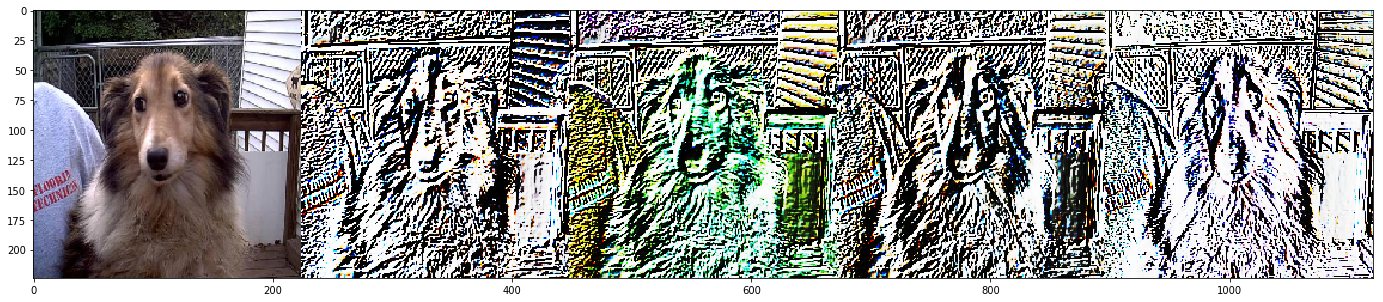

In [116]:
sample, _ = next(validation_generator)
sample = 256. - sample[0]
# escolha quais filtros voce quer visualizar
filters = [W[:,:,:, 0], W[:,:,:, 30], W[:,:,:, 35], W[:,:,:, -1]]

convolved_imgs = [sample]

for f in filters:
    convolved = convolve(sample, f)
    # para combinar os 3 canais, descomente as linhas abaixo
    # convolved[:,:,0] = convolved[:,:,0] +  convolved[:,:,1] +  convolved[:,:,2]
    # convolved = convolved[:,:,:1]
    convolved = (1. + convolved / (1. + np.abs(convolved))) * 0.5
    convolved_imgs.append(convolved)

stitched = utils.stitch_images(convolved_imgs,margin=0, cols=8)
    
plt.imshow(stitched)

plt.show()

Isso nos mostra que nas camadas iniciais, o modelo aprendeu no dataset ImageNet a detectar bordas e cores. 

Passar os filtros da segunda camada de convolução diretamente na imagem original não produz resultados satisfatórios, por que esses são construídos para tratar as features produzidas pelas camadas anteriores, ou seja: uma imagem com 64 canais.

### Qual o padrão reconhecido por cada neurônio

Uma segunda idéia mais interessante, seria tomar os filtros nas primeiras camadas de convolução, e ver qual o padrão que faz com que suas ativações sejam máximas. É possível fazer isso fazendo um gradiente ascendente no espaço de pixels, utilizando as derivadas da imagem de entrada e otimizando com gradiente ascendente respeito à ativação de um determinado neurônio.

Para entender os detalhes como é feito esse processo de otimização, cheque [optmizer.py](./vis/optimizer.py) e [activation_maximization.py](./vis/visualization/activation_maximization.py).

Para mais detalhes, veja o pacote ```keras-vis``` no [github](https://github.com/raghakot/keras-vis), que possui essas fantásticas funções implementadas, assim como exemplos de utilização, e pode ser instalado via ```pip```.

Aqui precisamos alterar a ativação da última camada para linear, para que a softmax não faça com que o processo de otimização "trapaceie" diminuindo uma ativação ao invés de aumentar a outra. Para entender por que isso acontece, visite [Neural Networks and Deep Learning: Chapter 3 - Softmax](http://neuralnetworksanddeeplearning.com/chap3.html#softmax)

In [6]:
model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

/home/sage/envs/playground/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


100%|██████████| 32/32 [05:37<00:00, 10.56s/it]


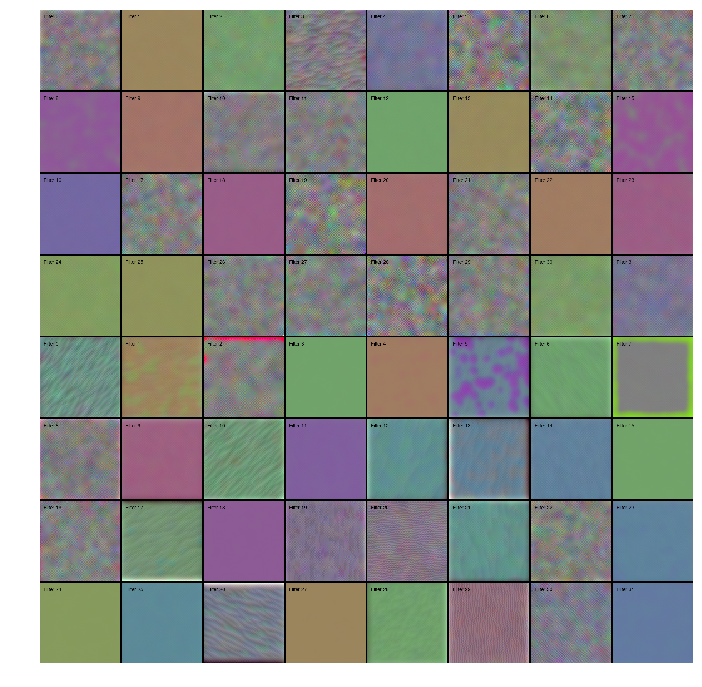

In [117]:
# Selecione na definição do modelo, qual camada deseja visualizar, neste caso usamos
# a segunda camada de convoluçao logo após a entrada
plt.rcParams['figure.figsize'] = (36, 12)
layer_name = 'block1_conv1'

layer_idx = utils.find_layer_idx(model, layer_name)

filters = np.arange(get_num_filters(model.layers[layer_idx]))

vis_images = []

# existem 64 filtros na camada block1_conv2, e cada filtro demora 
# na média 5 - 10s para ser processado na minha máquina, então os 64 
# demorariam ~10min

for idx in tqdm(filters[:32]):
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)
    
layer_name = 'block1_conv2'

layer_idx = utils.find_layer_idx(model, layer_name)

filters = np.arange(get_num_filters(model.layers[layer_idx]))

for idx in tqdm(filters[:32]):
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

stitched = utils.stitch_images(vis_images, cols=8)    

plt.rcParams['figure.figsize'] = (36, 12)

plt.axis('off')
plt.imshow(stitched)
plt.show()

Essas figuras representam o padrão que cada um dos neurônios analisados estão buscando na imagem de entrada, ou seja, a imagem com a qual sua ativação é máxima.

### E o que será que acontece se tentar visualizar a imagem que mais maximiza o neurônio "gato"?

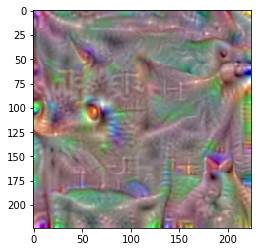

In [7]:
img = visualize_activation(model, -1, filter_indices=0)
plt.imshow(img)

### :0

### Agora os cachorros!

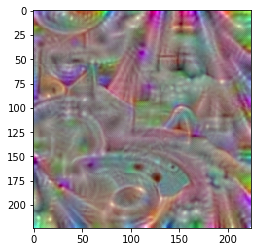

In [8]:
img = visualize_activation(model, -1, filter_indices=1)
plt.imshow(img)

Em um modelo mais complexo, com mais neurônios, os padrões ficam mais perceptíveis, como nesse exemplo, em que a camada totalmente conectada possui 1024 neurônios:

<div style='display:flex;padding:0;margin:0'>
    <img style="width:33%;height:10%;padding:0;margin:0" src="images/cat_1024.png">
    <img style="width:33%;height:10%;padding:0;margin:0" src="images/dog_1024.png">
<div>

Leia: 
* [Feature Visualization - Distill](https://distill.pub/2017/feature-visualization/)

### Visualizando a atenção da rede neural

Até agora conseguimos descobrir quais as features de baixo nível são observadas pela rede neural. Isso nos perceber descobrir quando a rede está alguma parte "morta" ou redundante, melhorando a debugação e facilitando o ajuste de hyperparâmetros, como o dropout. 

Agora vamos entrar no nível de compreensão do modelo. E tentar entender por quê ela decide por uma classe ou outra. 

Uma abordagem interessante é a técnica de visualização de ativação por classe apresentada em [Learning Deep Features for Discriminative Localization](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)

{'dog': -1.9351031, 'cat': 5.0035138}
predicted class: cat


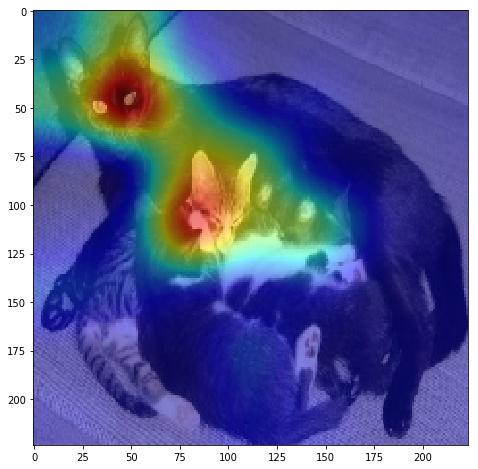

In [32]:
sample, _ = next(validation_generator)
y_pred = model.predict(sample)

layer_idx = utils.find_layer_idx(model, 'predictions')

cat_score, dog_score = y_pred[0][0], y_pred[0][1]

print({'cat': cat_score, 'dog': dog_score})
print('predicted class:', 'cat' if cat_score > dog_score else 'dog')

predicted = np.argmax(y_pred[0])

grads = visualize_cam(model, layer_idx, filter_indices=predicted, seed_input=sample, backprop_modifier=None)

plt.imshow(overlay(grads, sample[0]))

# t-SNE

No início deste notebook, falamos a respeito do fato de uma rede convolucional ser capaz de mapear imagens conceitual ou semanticamente semelhantes próximas num mesmo espaço N-dimensional. Esse espaço N-dimensional é a saída da última camada de convolução e a entrada para o nosso classificador nesta arquitetura (possui análogos em outras arquiteturas baseadas em global average pooling).

Seria interessante visualizar e explorar esse espaço, para descobrir qual critério de semelhança a rede utiliza, e como ela interpreta o domínio do problema. 

Infelizmente, visualizar um espaço de 32 dimensões é humanamente impossível, mas podemos utilizar técnicas de redução de dimensionalidade para mapear esse espaço em 2 ou 3 dimensões, permitindo-nos plotar as imagens neste espaço reduzido.

<div style='display:flex;padding:0;margin:0'>
    <img style="width:42%;height:10%;padding:0;margin:0" src="images/x-projection.png">
    <img style="width:50%;height:10%;padding:0;margin:0" src="images/tsne-projection.png">
    
<div>

Nas células a seguir utilizaremos o [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (Principal Component Analysis) seguido do [t-SNE](https://lvdmaaten.github.io/tsne/) (t-distributed Stochastic Neighbor Embedding) para mapear alguns exemplos do nosso dataset para um espaço bidimensional e transformar esse mapeamento em uma imagem.

* [Exemplos visuais interessantes de como o PCA funciona](http://setosa.io/ev/principal-component-analysis/)
* [PCA e SVD](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)
* [Intuição do t-SNE](https://www.youtube.com/watch?v=NEaUSP4YerM)
* [How to Use t-SNE Effectively - Distill](https://distill.pub/2016/misread-tsne/)

Vamos agora remover a camada de predição 'predictions/Softmax' e criar um novo modelo a partir do anterior, com essas camadas removidas. Vamos salvar esse novo modelo em disco, para podermos remover o anterior da memória e não causar Resource Exhausted em nossa GPU.

In [4]:
K.clear_session()

with open(model_location, 'r') as myfile:
    model_json = myfile.read()

model = model_from_json(model_json)
model.load_weights(weights_location)

headless_model = Model(inputs=model.input, outputs=model.get_layer('fc1').output)

!touch {headless_weights_location}

headless_model.save_weights(headless_weights_location)

headless_model_json_final = headless_model.to_json()

with open(headless_model_location, 'w+') as json_file:
    json_file.write(headless_model_json_final)

In [4]:
# Recarregando o modelo sem a camada de predição a partir do disco

K.clear_session()

with open(headless_model_location, 'r') as myfile:
    headless_model_json = myfile.read()

headless_model = model_from_json(headless_model_json)
headless_model.load_weights(headless_weights_location)

In [119]:
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(directory=validation_data_dir,
                                                              target_size=[img_width, img_height],
                                                              batch_size=1,
                                                              class_mode='categorical',
                                                              follow_links=True, 
                                                              shuffle=False)

Found 1240 images belonging to 2 classes.


Vamos calcular os vetores para 1000 imagens (o suficiente para que consigamos visualizar)

In [5]:
nb_tsne = 1000

filenames = []
vectors = []

for i in tqdm(range(nb_tsne)):
    sample, _ = next(validation_generator)
    # pega o nome do arquivo, para podermos plotar a imagem novamente
    filename = validation_generator.filenames[validation_generator.batch_index - 1]
    filenames.append(filename)
    vectors.append(headless_model.predict(sample)[0])    

100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]


Vamos persistir este arquivo em disco pra facilitar a nossa vida se precisarmos dele depois.

In [6]:
filenames_and_vectors = {}
filenames_and_vectors['files'] = np.asarray(filenames)
filenames_and_vectors['data'] = np.asarray(vectors)

with open(files_and_vector_location, 'wb+') as f:
    dump(filenames_and_vectors, f)

del filenames_and_vectors
del filenames
del vectors

In [7]:
with open(files_and_vector_location, 'rb') as f:
    filenames_and_vectors = load(f)

data_vecs = filenames_and_vectors['data']
image_names = filenames_and_vectors['files']

perm = np.random.permutation(data_vecs.shape[0])
data_vecs = data_vecs[perm]
image_names = image_names[perm]

Caso a sua dimensão de saída seja maior que n=50, recomenda-se que a dimensionalidade seja primeiro reduzida para algo próximo disso usando um redutor como o PCA, ou SVD, para que depois seja aplicado o t-SNE, para melhorar a qualidade dos vetores, e reduzir o tempo de cálculo dos kNNs envolvidos na computação.

```python
print('dimension reduction using svd')
print ('dimension before: {}'.format(str(data_vecs.shape[1])))
data_vecs = TruncatedSVD(n_components=50, random_state=0).fit_transform(data_vecs)
print ('dimension after: {}'.format(str(data_vecs.shape[1])))
```

Em nosso caso, a saída da camada totalmente conectada é de n=32, então aplicamos diretamente o t-SNE. 

Dados de dimensionalidade maior costumam produzir embeddings mais interessantes. Em uma versão anterior, o embedding com n=1024, após o SVD para 50 e a aplicação do t-SNE resultou nesta [imagem](https://drive.google.com/open?id=11Xlw_b_Y1Hc7mnJpLTmCpnEm4XZ-8PZC) (37.3MB).

In [9]:
tsne_vecs = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(data_vecs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.135s...
[t-SNE] Computed neighbors for 1000 samples in 0.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.950186
[t-SNE] Computed conditional probabilities in 0.223s
[t-SNE] Iteration 50: error = 61.0173111, gradient norm = 0.2769552 (50 iterations in 0.951s)
[t-SNE] Iteration 100: error = 60.1447487, gradient norm = 0.2694899 (50 iterations in 0.860s)
[t-SNE] Iteration 150: error = 59.9788589, gradient norm = 0.2535627 (50 iterations in 0.839s)
[t-SNE] Iteration 200: error = 59.8236923, gradient norm = 0.2627078 (50 iterations in 0.828s)
[t-SNE] Iteration 250: error = 59.9351883, gradient norm = 0.2682140 (50 iterations in 0.836s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.935188
[t-SNE] Iteration 300: error = 1.0858399, gradient norm = 0.0016353 (50 iterations in 0.840s)
[t-SNE] Iteration 350: error = 1.0078582, gradient norm = 0.0003

Vamos usar o matplotlib para gerar uma figurinha bonitinha pra gente:

0it [00:00, ?it/s]/home/sage/envs/playground/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
1000it [00:18, 54.89it/s]


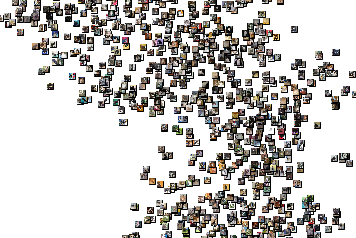

In [10]:
fig = plt.gcf()
fig.clf()
ax = plt.subplot(111)

for img_path, xy in tqdm(zip(image_names, tsne_vecs)):
    arr_hand = resize(imread(validation_data_dir + '/' + img_path), (300, 300))
    imagebox = OffsetImage(arr_hand, zoom=.02)
    ab = AnnotationBbox(imagebox, xy, pad=0.0,
    xycoords='data',
    boxcoords="offset points")                                  
    ax.add_artist(ab)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

plt.xlim(( min(tsne_vecs[:, 0]), max(tsne_vecs[:, 0]) ))
plt.ylim(( min(tsne_vecs[:, 1]), max(tsne_vecs[:, 1]) ))

fig.savefig('./images/tsne.jpg', dpi=1800)